# Credit Risk Analysis and prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.metrics import confusion_matrix, precision_recall_curve, fbeta_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from xgboost import XGBClassifier

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

pd.set_option('display.max_columns', 100)

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [3]:
df = df_credit = pd.read_csv("../../Data/german_credit_data.csv",index_col=0)

## Filling missing data

In [4]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [5]:
print(df['Saving accounts'].unique())
df['Saving accounts'][df['Saving accounts'].isna()] = 'None'
print(df['Saving accounts'].unique())

[nan 'little' 'quite rich' 'rich' 'moderate']
['None' 'little' 'quite rich' 'rich' 'moderate']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
print(df['Checking account'].unique())
df['Checking account'][df['Checking account'].isna()] = 'None'
print(df['Checking account'].unique())

['little' 'moderate' nan 'rich']
['little' 'moderate' 'None' 'rich']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [8]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

## Data Analysis

proportion of good credit:  0.7
proportion of bad credit:  0.3


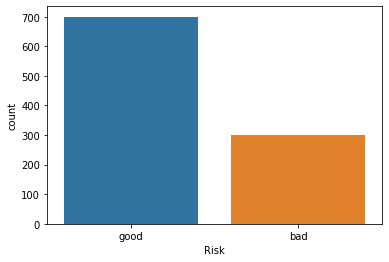

In [9]:
sns.countplot(x=df['Risk'])
print('proportion of good credit: ', sum(sum([df['Risk']=='good']))/len(df))
print('proportion of bad credit: ', sum(sum([df['Risk']=='bad']))/len(df))

70% of the credits in the dataset are labelled 'bad'

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


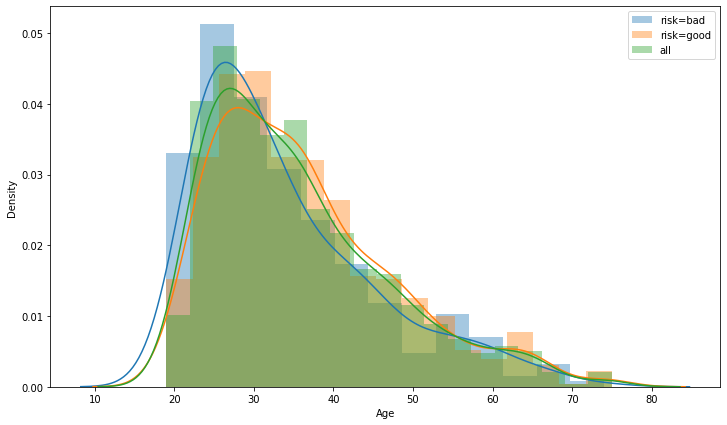

In [10]:
plt.figure(figsize = (12, 7))
sns.distplot(df['Age'][df['Risk']=='bad'], label = 'risk=bad')
sns.distplot(df['Age'][df['Risk']=='good'], label = 'risk=good')
sns.distplot(df['Age'], label='all')
plt.legend()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


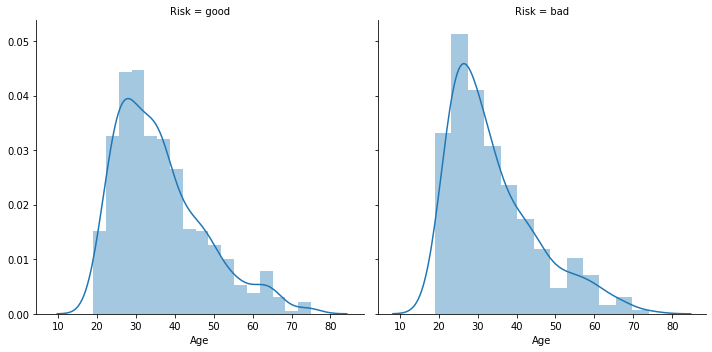

In [11]:
g = sns.FacetGrid(df, col="Risk", height=5, aspect=1)
g.map(sns.distplot, "Age")

 Younger people appear to be more at risk for bad credit than older people

proportion of fail for category 0: 31.8%
proportion of fail for category 1: 28.0%
proportion of fail for category 2: 29.5%
proportion of fail for category 3: 34.5%


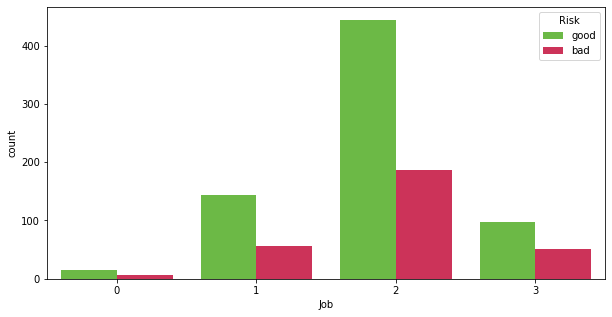

In [12]:
plt.figure(figsize = (10, 5))
sns.countplot(data=df, x='Job', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])
categories = df['Job'].unique()
categories.sort()

for category in categories:
    fail = len((df)[(df['Job']==category) & (df['Risk']=='bad')]) / len((df)[(df['Job']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

<AxesSubplot:xlabel='Job', ylabel='Credit amount'>

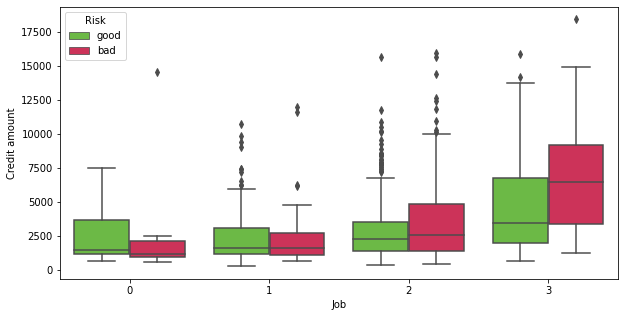

In [13]:
plt.figure(figsize = (10, 5))
sns.boxplot(data=df, x='Job', y='Credit amount', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])

Most of the credits are made by people in job category 2, but the proportion of bad credits is similar for each category  
Nonetheless, the highest credits are made by job category 3, and the largest variation is made by category 0   
People in category 3 fail more often

proportion of fail for category own: 26.1%
proportion of fail for category free: 40.7%
proportion of fail for category rent: 39.1%


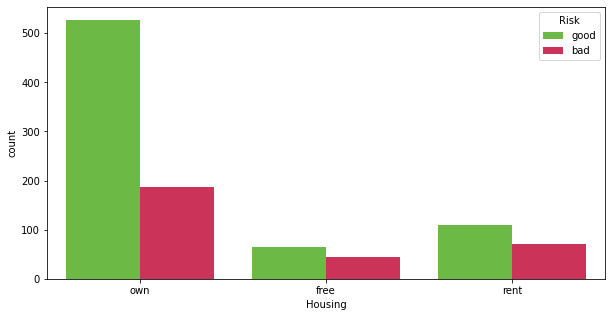

In [14]:
plt.figure(figsize = (10, 5))
sns.countplot(x='Housing', hue='Risk', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Housing'].unique()
for category in categories:
    fail = len((df)[(df['Housing']==category) & (df['Risk']=='bad')]) / len((df)[(df['Housing']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

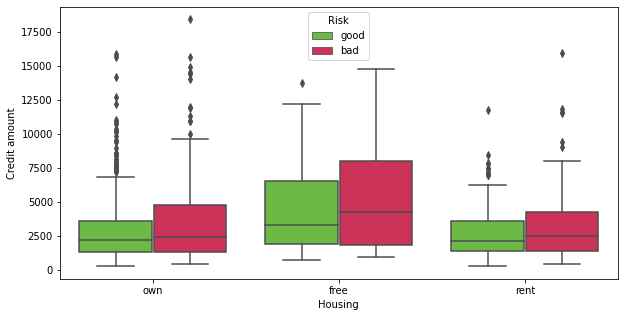

In [15]:
plt.figure(figsize = (10, 5))
sns.boxplot(x='Housing', hue='Risk', y='Credit amount', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

People owning their own house tend to make more credits, and have a lower proportion of fail  
Those who are free housing make larger credits

proportion of fail for category None: 17.5%
proportion of fail for category little: 36.0%
proportion of fail for category quite rich: 17.5%
proportion of fail for category rich: 12.5%
proportion of fail for category moderate: 33.0%


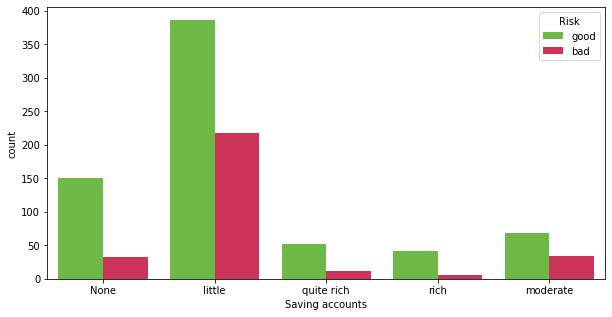

In [16]:
plt.figure(figsize = (10, 5))
sns.countplot(x='Saving accounts', hue='Risk', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Saving accounts'].unique()
for category in categories:
    fail = len((df)[(df['Saving accounts']==category) & (df['Risk']=='bad')]) / len((df)[(df['Saving accounts']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

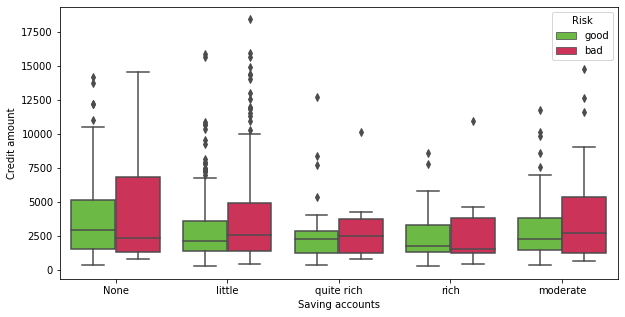

In [17]:
plt.figure(figsize = (10, 5))
sns.boxplot(x='Saving accounts', hue='Risk', y='Credit amount', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

People with little saving account make more credits than other categories, with a higher proportion a failing.  
Poeple with moderate saving fail quite often as well.  
Nonetheless, each category makes credit of similar amount.  
Rich people have a larger variation, meaning they are more susceptible to borrow large amounts

proportion of fail for category radio/TV: 22.1%
proportion of fail for category education: 39.0%
proportion of fail for category furniture/equipment: 32.0%
proportion of fail for category car: 31.5%
proportion of fail for category business: 35.1%
proportion of fail for category domestic appliances: 33.3%
proportion of fail for category repairs: 36.4%
proportion of fail for category vacation/others: 41.7%


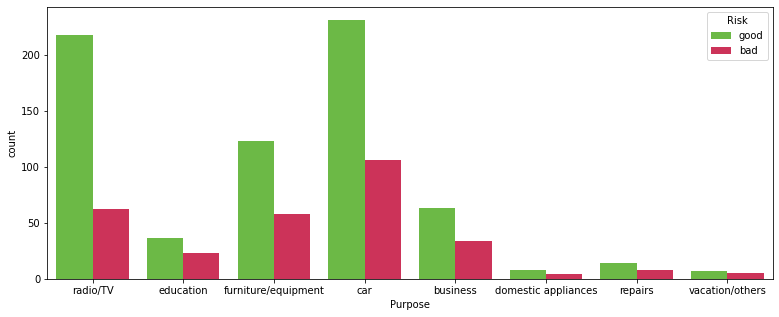

In [18]:
plt.figure(figsize = (13, 5))
sns.countplot(data=df, x='Purpose', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Purpose'].unique()
for category in categories:
    fail = len((df)[(df['Purpose']==category) & (df['Risk']=='bad')]) / len((df)[(df['Purpose']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

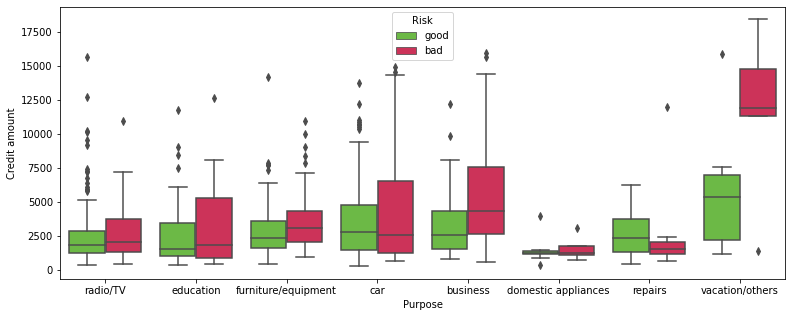

In [19]:
plt.figure(figsize = (13, 5))
sns.boxplot(data=df, x='Purpose', hue='Risk', y='Credit amount', palette=[(.4, .8, .2), (.9, .1, .3)])

Very interesting plot, as credits made for vacation have the largest proportion of failing. 
Business is second in raking of failing purpose  
People tend to make more credits to buy radio/TV and cars.  
Every category is more susceptible to lead to a failing credit than to success...

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


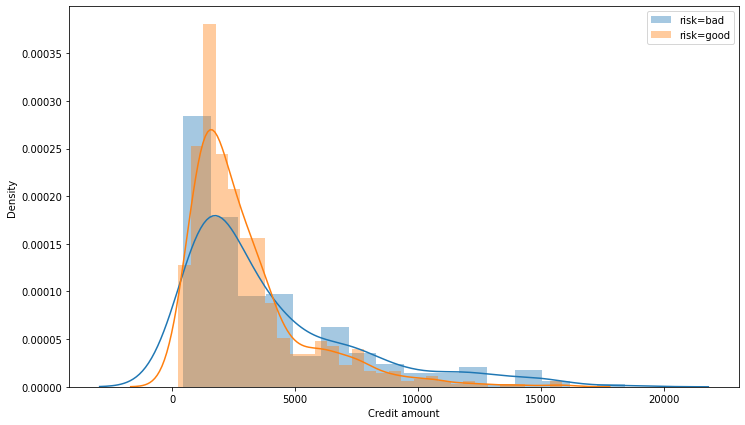

In [20]:
plt.figure(figsize = (12, 7))
sns.distplot(df['Credit amount'][df['Risk']=='bad'], label = 'risk=bad')
sns.distplot(df['Credit amount'][df['Risk']=='good'], label = 'risk=good')
plt.legend()

High credit amounts fail more often than low credit. 

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


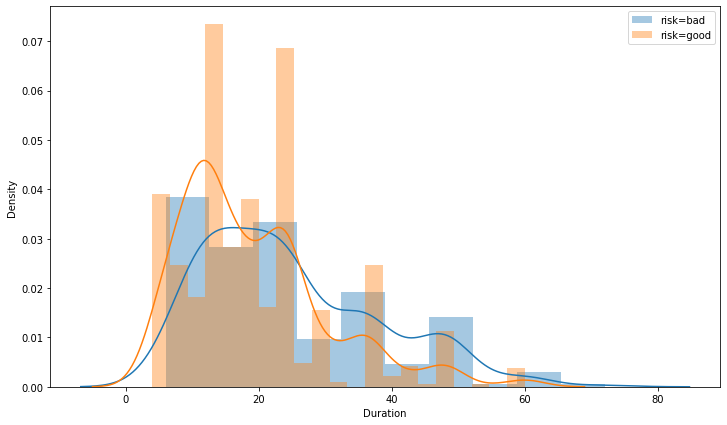

In [21]:
plt.figure(figsize = (12, 7))
sns.distplot(df['Duration'][df['Risk']=='bad'], label = 'risk=bad')
sns.distplot(df['Duration'][df['Risk']=='good'], label = 'risk=good')
plt.legend()

Credits engaged on a long duration happen to fail more than on short duration, which follows the previous plot: larger credits lead to longer duration, hence failing more ofter

proportion of fail for category male: 27.7%
proportion of fail for category female: 35.2%


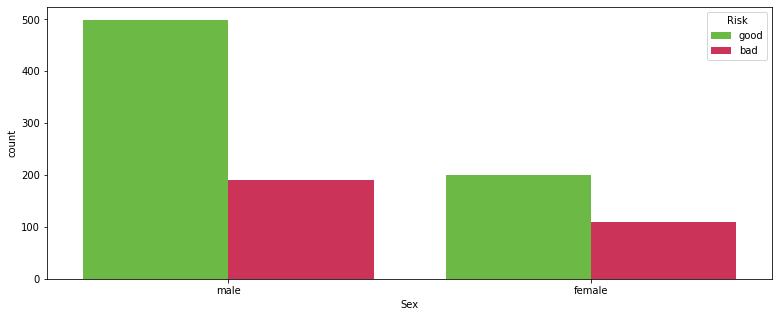

In [22]:
plt.figure(figsize = (13, 5))
sns.countplot(data=df, x='Sex', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Sex'].unique()
for category in categories:
    fail = len((df)[(df['Sex']==category) & (df['Risk']=='bad')]) / len((df)[(df['Sex']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

<AxesSubplot:xlabel='Sex', ylabel='Credit amount'>

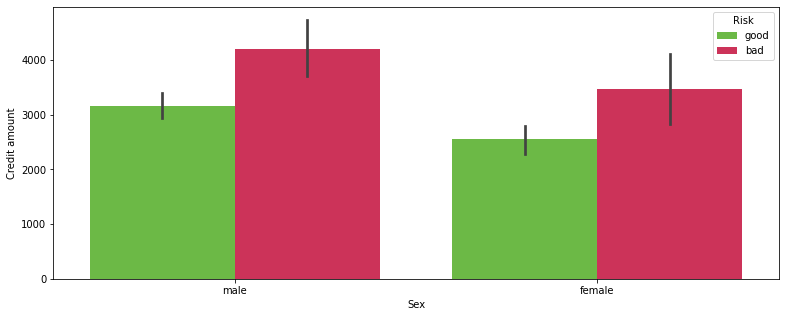

In [23]:
plt.figure(figsize = (13, 5))
sns.barplot(data=df, x='Sex', hue='Risk', y='Credit amount', palette=[(.4, .8, .2), (.9, .1, .3)])

Males engage more credits than females, but they fail less often in proportion than females  
Males also tend to borrow larger amounts, and also fail on the largest ones.  
The variation of amounts is similar for males and females

In [10]:
df_inter=pd.DataFrame()
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

for col in categorical_features:
    dummies = pd.get_dummies(df[col],prefix=col)
    df_inter = pd.concat([df_inter, dummies], axis=1)
    
df = pd.concat([df, df_inter], axis=1)
df = df.drop(categorical_features, axis=1)


    
continuous_features = ['Age', 'Credit amount', 'Duration']
for col in continuous_features:
    column = np.array(df[col])
    column = column.reshape(len(column), 1)
    sc = StandardScaler()
    sc.fit(column)
    df[col] = sc.transform(column)
    
    

y = df['Risk_good']
X=df.drop(['Risk_good', 'Risk_bad'], axis=1)

In [11]:
y = df['Risk_bad']

In [12]:
df= df.drop(['Risk_bad'], axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

### Find best parameters for Random Forest

In [ ]:
#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

Prediction with RF

In [59]:
rf = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=5, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=20, n_estimators=5, random_state=0)

In [60]:
prediction = rf.predict(X_test)

In [61]:
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(X_test)

# Validation of the results
print(accuracy_score(y_test,prediction))
print("\n")
print(confusion_matrix(y_test, prediction))
print("\n")
print(fbeta_score(y_test, prediction, beta=2))
print("\n")
print(classification_report(y_test, prediction))

0.716


[[150  28]
 [ 43  29]]


0.42028985507246386


              precision    recall  f1-score   support

           0       0.78      0.84      0.81       178
           1       0.51      0.40      0.45        72

    accuracy                           0.72       250
   macro avg       0.64      0.62      0.63       250
weighted avg       0.70      0.72      0.71       250



### Test with XGBoost

In [ ]:
XGBModel = XGBClassifier()
XGBModel.fit(X_train, y_train , verbose=1)

#Testing the model 
#Predicting using our  model
XGBpredictions = XGBModel.predict(X_test)

In [ ]:
# Validation of the results
print(accuracy_score(y_test,XGBpredictions))
print("\n")
print(confusion_matrix(y_test, XGBpredictions))
print("\n")
print(fbeta_score(y_test, XGBpredictions, beta=2))
print("\n")
print(classification_report(y_test, XGBpredictions))

### Gaussian Naive Bayes model

In [ ]:
GNBModel = GaussianNB()
GNBModel.fit(X_train, y_train)

#Testing the model 
#Predicting using our  model
GNBpredictions = GNBModel.predict(X_test)

In [ ]:
# Validation of the results
print(accuracy_score(y_test,GNBpredictions))
print("\n")
print(confusion_matrix(y_test, GNBpredictions))
print("\n")
print(fbeta_score(y_test, GNBpredictions, beta=2))
print("\n")
print(classification_report(y_test, GNBpredictions))

## Neural Network Model

In [ ]:
y_test_categorical = to_categorical(
    y_test, num_classes=2, dtype='float32')
y_train_categorical = to_categorical(
    y_train, num_classes=2, dtype='float32')

In [ ]:
def nn_model(learning_rate):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(2, kernel_initializer='normal',activation='sigmoid'))

    # Compile the network :
    optimizer = Adam(learning_rate=1e-5)
    NN_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    NN_model.summary()
    return NN_model

In [ ]:
NN_model = nn_model(1e-4)
nb_epochs = 200
NN_model.fit(X_train, y_train_categorical, epochs=nb_epochs, batch_size=32)

In [ ]:
NNpredictions = NN_model.predict(X_test)

NN_prediction = list()
for i in range(len(NNpredictions)):
    NN_prediction.append(np.argmax(NNpredictions[i]))

In [ ]:
# Validation of the results
print(accuracy_score(y_test, NN_prediction))
print("\n")
print(confusion_matrix(y_test, NN_prediction))
print("\n")
print(fbeta_score(y_test, NN_prediction, beta=2))
print("\n")
print(classification_report(y_test, NN_prediction))

The Neural Network is the best model found so far.. reaching accuracy of 74%.  

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, NNpredictions[:, 1])

lr_auc = roc_auc_score(y_test, NNpredictions[:, 1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='No Skill: ROC AUC=%.3f' % (0.5))
plt.plot(fpr, tpr, label='Logistic: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
NN_model = nn_model(1e-4)
nb_epochs = 200
NN_model.fit(X_train, y_train_categorical, epochs=nb_epochs, batch_size=32)

optimizer = Adam(learning_rate=5e-5)
NN_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
nb_epochs = 200
NN_model.fit(X_train, y_train_categorical, epochs=nb_epochs, batch_size=32)

In [ ]:
NNpredictions = NN_model.predict(X_test)

NN_prediction = list()
for i in range(len(NNpredictions)):
    NN_prediction.append(np.argmax(NNpredictions[i]))

In [ ]:
# Validation of the results
print(accuracy_score(y_test, NN_prediction))
print("\n")
print(confusion_matrix(y_test, NN_prediction))
print("\n")
print(fbeta_score(y_test, NN_prediction, beta=2))
print("\n")
print(classification_report(y_test, NN_prediction))

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, NNpredictions[:, 1])

lr_auc = roc_auc_score(y_test, NNpredictions[:, 1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='No Skill: ROC AUC=%.3f' % (0.5))
plt.plot(fpr, tpr, label='Logistic: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## SVM model

In [ ]:
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train)

In [ ]:
SVMpredictions = clf.predict(X_test)

In [ ]:
# Validation of the results
print(accuracy_score(y_test,SVMpredictions))
print("\n")
print(confusion_matrix(y_test, SVMpredictions))
print("\n")
print(fbeta_score(y_test, SVMpredictions, beta=2))
print("\n")
print(classification_report(y_test, SVMpredictions))

## Fairness

In [13]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [14]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [15]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [16]:
df = df.drop(['Sex_female'], axis = 1)
df

,Age,Credit amount,Duration,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,Housing_rent,Saving accounts_None,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_None,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,2.766456,-0.745131,-1.236478,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
1,-1.191404,0.949817,2.248194,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1.183312,-0.416562,-0.738668,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,0.831502,1.634247,1.750384,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
4,1.535122,0.566664,0.256953,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.399832,-0.544162,-0.738668,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
996,0.391740,0.207612,0.754763,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
997,0.215835,-0.874503,-0.738668,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
998,-1.103451,-0.505528,1.999289,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [17]:
privileged_groups = [{'Sex_male': 1}]
unprivileged_groups = [{'Sex_male': 0}]
dataset_orig = StandardDataset(df,
                                  label_name='Risk_good',
                                  protected_attribute_names=['Sex_male'],
                                  favorable_classes=[0],
                                  privileged_classes=[[1]])


In [18]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.074801


In [145]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

num_estimators = 5

model = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=5)

mdl = model.fit(X_train, y_train)
with open('../../Results/RF/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/RF/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/RF/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [19]:
final_metrics = []
accuracy = []
f1= []
from statistics import mean
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

for i in range(0,20):
    
    data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
    print(i)
    X_train = data_orig_train.features
    y_train = data_orig_train.labels.ravel()

    X_test = data_orig_test.features
    y_test = data_orig_test.labels.ravel()
    model = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=5)

  
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)
    
element_wise_std =  np.std(final_metrics, 0, ddof=1)
print("STD " + str(element_wise_std))
final_metrics = list(map(mean, zip(*final_metrics)))
accuracy = mean(accuracy)
f1 = mean(f1)
final_metrics[4] = np.log(final_metrics[4])
print(final_metrics)
print(sum(final_metrics[1:]))
print(accuracy)
print(f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
STD [5.91607978 0.05319522 0.12101701 0.04672445 0.26984899 0.03569782]
[9.5, 0.0688848363527227, 0.047897801117623505, 0.08350453955830192, 0.2664412370417714, 0.22426036434894203]
0.6909887784193616
0.6961666666666667
0.788819268618505


In [146]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = RandomForestClassifier(n_estimators=i, max_depth=None, max_features=20)

    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [150]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/RF/' + nb_fname + '.csv')
final_result

,classifier,T0,T1,T2,T3,T4
accuracy,0.726667,0.683333,0.746667,0.660000,0.743333,0.726667
f1,0.474359,0.431138,0.344828,0.400000,0.412214,0.474359
statistical_parity_difference,-0.100005,-0.094695,-0.023240,-0.033020,-0.077659,-0.100005
equal_opportunity_difference,-0.084411,-0.077691,-0.001222,-0.024030,-0.087160,-0.084411
average_abs_odds_difference,0.063039,0.070095,0.008944,0.014098,0.053997,0.063039
disparate_impact,-0.139056,-0.138520,-0.026752,-0.048084,-0.096180,-0.139056
theil_index,0.189460,0.238824,0.111322,0.261067,0.137499,0.189460


In [148]:
temp_final = list(final_result['classifier'])
average.append(temp_final)
len(average)

10

In [108]:
average = []

In [149]:
avg = [float(sum(col))/len(col) for col in zip(*average)]
avg

[0.706,
 0.4863351997749089,
 -0.07517438859017032,
 -0.043956519202038316,
 0.07491994855010395,
 -0.10797017917086835,
 0.19300124508827124]